In [1]:
import torch
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
cm=0.00047
rm=10000
rl=270
def rhs(s, v): 
    return [-v[0]*(1/(cm*rm) + 2/(cm*rl)) + v[1]/(cm*rl) + 11/(cm*rl), -v[1]*(1/(cm*rm) + 2/(cm*rl)) + v[0]/(cm*rl) + v[2]/(cm*rl), -v[2]*(1/(cm*rm) + 2/(cm*rl)) + v[1]/(cm*rl) + v[3]/(cm*rl), -v[3]*(1/(cm*rm) + 2/(cm*rl)) + v[2]/(cm*rl) + v[4]/(cm*rl), -v[4]*(1/(cm*rm) + 2/(cm*rl)) + v[3]/(cm*rl) + v[5]/(cm*rl), -v[5]*(1/(cm*rm) + 2/(cm*rl)) + v[4]/(cm*rl) + v[6]/(cm*rl), -v[6]*(1/(cm*rm) + 2/(cm*rl)) + v[5]/(cm*rl) + v[7]/(cm*rl), -v[7]*(1/(cm*rm) + 2/(cm*rl)) + v[6]/(cm*rl) + v[8]/(cm*rl), -v[8]*(1/(cm*rm) + 2/(cm*rl)) + v[7]/(cm*rl) + v[9]/(cm*rl), -v[9]*(1/(cm*rm) + 2/(cm*rl)) + v[8]/(cm*rl) + v[10]/(cm*rl), -v[10]*(1/(cm*rm) + 2/(cm*rl)) + v[9]/(cm*rl) + v[11]/(cm*rl), -v[11]*(1/(cm*rm) + 2/(cm*rl)) + v[10]/(cm*rl) + v[12]/(cm*rl), -v[12]*(1/(cm*rm) + 2/(cm*rl)) + v[11]/(cm*rl) + v[13]/(cm*rl), -v[13]*(1/(cm*rm) + 2/(cm*rl)) + v[12]/(cm*rl) + v[14]/(cm*rl), -v[14]*(1/(cm*rm) + 2/(cm*rl)) + (v[13])/(cm*rl)]
result = solve_ivp(rhs, (0, 10), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], t_eval=np.linspace(0, 10,num=2000))

In [2]:
max(result.y[0,:])

9.311181707887226

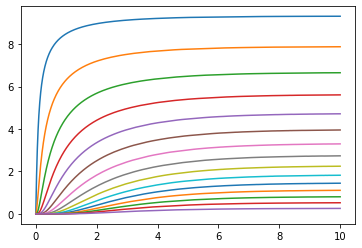

In [3]:
plt.plot(result.t, result.y[:,:].T)

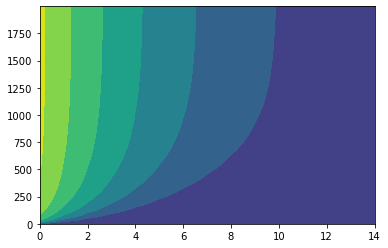

In [4]:
plt.contourf(result.y.T)

In [5]:
output_data=result.y[:10,:]
output_data.shape

(10, 2000)

In [6]:
from scipy.io import loadmat
# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import  Threshold, PDEFIND
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import TrainTestPeriodic

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
x = np.linspace(1,10,num=10)
x

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [8]:
t=result.t

In [9]:
x.shape

(10,)

In [10]:
t.shape

(2000,)

In [11]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
print(np.max(x_grid))
print(np.max(t_grid))
x_grid = x_grid/np.max(x_grid)
t_grid = t_grid/np.max(t_grid)

10.0
10.0


In [12]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(output_data).reshape((output_data.size, 1))
print(np.max(y))
y = y/np.max(y)

9.311181707887226


In [13]:
number_of_samples = 2000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [14]:
network = NN(2, [30, 30, 30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=1, diff_order=2) # Library function
estimator = PDEFIND(lam=1e-4) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [15]:
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=8, delta=1e-5) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

In [16]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/exp_data/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-5, patience=20) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
         50      0.05%            3738s   9.70e-02   9.70e-02   1.95e-07   3.74e+01 

/Users/akshay/anaconda3/envs/akshay/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.69514e-08): result may not be accurate.
  overwrite_a=True).T


         75      0.07%            3720s   7.66e-02   7.66e-02   1.36e-08   2.39e+02 

/Users/akshay/anaconda3/envs/akshay/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.84693e-09): result may not be accurate.
  overwrite_a=True).T


     100000    100.00%               0s   2.73e-05   2.36e-05   3.69e-06   1.82e+00 